In [1]:
from pymongo import MongoClient
import pandas as pd 
import numpy as np 
import os 

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def conn_db(): 

    user = os.getenv("DBUSER", 'signature')
    pwd = os.getenv("DBPWD", 'shanekang')
    ip_addr = os.getenv("DBADDR", '54.180.213.105')

    conn = MongoClient(f'mongodb://{user}:{pwd}@{ip_addr}:27017') 
    return conn

def get_confirmed_data(): 

    conn = conn_db() 

    domestic_cumul_collection = conn.DomesticCOVID.domestic_cumul 

    total_data = [[elem['date'], elem['confirmed']] for elem in domestic_cumul_collection.find({})]

    conn.close() 

    confirmed_df = pd.DataFrame(total_data, columns=['date', 'confirmed'])
    confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
    

    return confirmed_df

confirmed_df = get_confirmed_data() 
confirmed_df

,date,confirmed
0,2020-01-21,1
1,2020-01-22,1
2,2020-01-23,1
3,2020-01-24,2
4,2020-01-25,2
...,...,...
298,2020-11-14,28338
299,2020-11-15,28546
300,2020-11-16,28769
301,2020-11-17,28998


In [3]:
data = confirmed_df['confirmed'].to_numpy()
data[:5]

array([1, 1, 1, 2, 2], dtype=int64)

In [4]:
def to_confirmed_day(data): 
    diff = [data[0]]
    for i in range(1, len(data)): 
        diff.append(data[i]-data[i-1])
    return np.array(diff)
data = to_confirmed_day(data)
data[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [5]:
from sklearn.preprocessing import StandardScaler

sdsc = StandardScaler() 
scaled_data = sdsc.fit_transform(data[:,None]) 
scaled_data[:5]

array([[-0.81216147],
       [-0.82064482],
       [-0.82064482],
       [-0.81216147],
       [-0.82064482]])

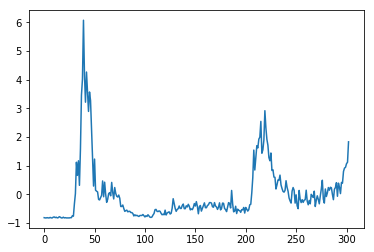

In [6]:
plt.plot(scaled_data)

In [7]:
val_size = 21
train = scaled_data[:-val_size*2]
val = scaled_data[-val_size*2:-val_size]
test = scaled_data[-val_size:]
train.shape, val.shape, test.shape

((261, 1), (21, 1), (21, 1))

In [8]:
def create_dataset(data, look_back=1):
    X_data, y_data = list(), list()
    
    for i in range(len(data)-look_back):
        X_data.append(data[i:i+look_back, 0])
        y_data.append(data[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

look_back = 14
X_train, y_train = create_dataset(train, look_back=look_back) 
X_val, y_val = create_dataset(val, look_back=look_back) 
X_test, y_test = create_dataset(test, look_back=look_back) 
X_train.shape, X_val.shape, X_test.shape

((247, 14), (7, 14), (7, 14))

In [9]:
def reshape_data(data): 
    return np.reshape(data, (data.shape[0], data.shape[1], 1))
X_train = reshape_data(X_train)
X_val = reshape_data(X_val)
X_test = reshape_data(X_test)

X_train.shape, X_val.shape, X_test.shape

((247, 14, 1), (7, 14, 1), (7, 14, 1))

In [10]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, ReLU
import tensorflow as tf 

np.random.seed(64) 

In [11]:
model = Sequential()
# for i in range(2):
#     model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
#     model.add(Dropout(0.2))
# model.add(LSTM(16, batch_input_shape=(1, look_back, 1), stateful=True))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(Dense(32, input_shape=(1, look_back, 1)))
model.add(ReLU())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 14, 32)         64        
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 14, 32)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 14, 1)          33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [12]:
class CustomHistory(tf.keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        
custom_hist = CustomHistory()
custom_hist.init()

In [13]:
save_best = tf.keras.callbacks.ModelCheckpoint('temp_best.h5', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=5, verbose=0, mode='auto')
model.fit(X_train, y_train, epochs=200, batch_size=1, shuffle=False,
         callbacks=[custom_hist, save_best, early_stop], validation_data=(X_val, y_val))

W1119 13:44:48.226133 28500 functional.py:587] Model was constructed with shape (None, 1, 14, 1) for input Tensor("dense_input:0", shape=(None, 1, 14, 1), dtype=float32), but it was called on an input with incompatible shape (1, 14, 1, 1).


Epoch 1/200


W1119 13:44:48.339345 28500 functional.py:587] Model was constructed with shape (None, 1, 14, 1) for input Tensor("dense_input:0", shape=(None, 1, 14, 1), dtype=float32), but it was called on an input with incompatible shape (1, 14, 1, 1).


227/247 [==========================>...] - ETA: 0s - loss: 1.0143

W1119 13:44:49.354114 28500 functional.py:587] Model was constructed with shape (None, 1, 14, 1) for input Tensor("dense_input:0", shape=(None, 1, 14, 1), dtype=float32), but it was called on an input with incompatible shape (1, 14, 1, 1).


247/247 [==============================] - 1s 3ms/step - loss: 0.9417 - val_loss: 0.0985
Epoch 2/200
247/247 [==============================] - 0s 1ms/step - loss: 0.8779 - val_loss: 0.1077
Epoch 3/200
247/247 [==============================] - 0s 2ms/step - loss: 0.8745 - val_loss: 0.1095
Epoch 4/200
247/247 [==============================] - 0s 2ms/step - loss: 0.8717 - val_loss: 0.1103
Epoch 5/200
247/247 [==============================] - 0s 2ms/step - loss: 0.8689 - val_loss: 0.1108
Epoch 6/200
247/247 [==============================] - 0s 2ms/step - loss: 0.8660 - val_loss: 0.1112


In [14]:
# for i in range(200):
#     model.fit(X_train, y_train, 
#               epochs=1, 
#               batch_size=1, 
#               shuffle=False, 
#               callbacks=[custom_hist], 
#               validation_data=(X_val, y_val))
#     model.reset_states()

In [15]:
model = tf.keras.models.load_model('temp_best.h5')

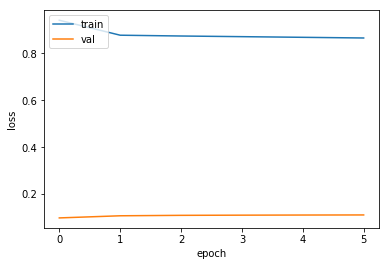

In [16]:
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
# plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
trainScore = model.evaluate(X_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

valScore = model.evaluate(X_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)

testScore = model.evaluate(X_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

W1119 13:44:51.624338 28500 functional.py:587] Model was constructed with shape (None, 1, 14, 1) for input Tensor("dense_input_1:0", shape=(None, 1, 14, 1), dtype=float32), but it was called on an input with incompatible shape (1, 14, 1, 1).


Train Score:  0.8217664957046509
Validataion Score:  0.09854839742183685
Test Score:  0.7620455622673035


W1119 13:44:51.990198 28500 functional.py:587] Model was constructed with shape (None, 1, 14, 1) for input Tensor("dense_input_1:0", shape=(None, 1, 14, 1), dtype=float32), but it was called on an input with incompatible shape (1, 14, 1, 1).


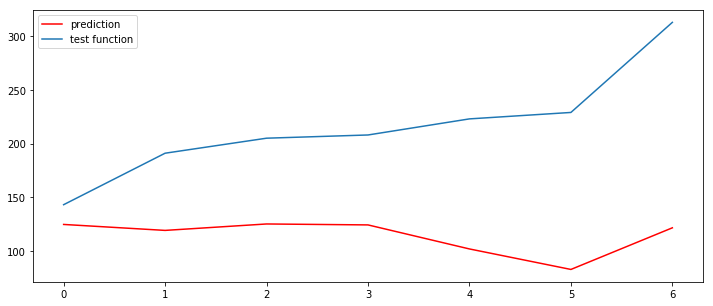

In [18]:
look_ahead = 7
xhat = X_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    prediction = [elem[0] for elem in prediction][0]
    predictions[i] = prediction[0]
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), 
         sdsc.inverse_transform(predictions),
         'r',label="prediction")
plt.plot(np.arange(look_ahead), sdsc.inverse_transform(y_test[:look_ahead]),label="test function")
plt.legend()
plt.show()

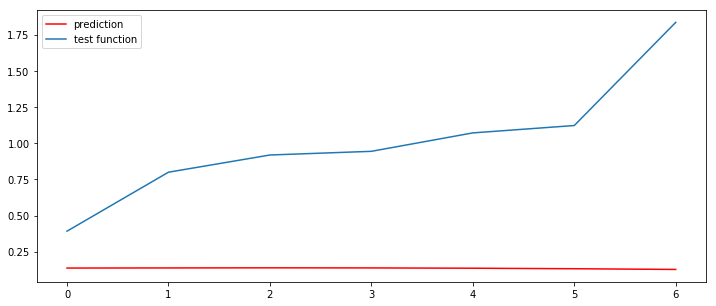

In [176]:
look_ahead = 7
xhat = X_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead), y_test[:look_ahead],label="test function")
plt.legend()
plt.show()